In [19]:
import tensorflow as tf
from tensorflow import keras
from plantcv import plantcv as pcv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
print(tf.__version__)
print(pd.__version__)

2.11.0
1.5.3


In [21]:
# How many parameters are we inputing into our model
num_parameters = 13 

In [22]:
# See if there are any GPUs that can be used to run our code
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [23]:
csv_filepath = "C:\\Users\\saaha\\OneDrive\\Documents\\GitHub\\BiomassPredictonAI\\harvest_bydate.csv"

In [24]:
data = pd.read_csv(csv_filepath)
input_data = data.iloc[:, 12:]
input_data

,plant_area,plant_convex_hull_area,plant_solidity,plant_perimeter,plant_width,plant_height,plant_longest_path
0,1211,1456.0,0.831731,189.923880,49,42,346
1,1412,1556.5,0.907164,181.338094,56,41,387
2,1323,1766.5,0.748939,225.480229,49,54,332
3,1621,1787.0,0.907107,195.580734,44,59,395
4,1919,2372.0,0.809022,263.421354,62,58,453
...,...,...,...,...,...,...,...
79,3590,4191.5,0.856495,313.279218,88,68,710
80,2832,3384.0,0.836879,272.007140,57,75,595
81,2714,3456.5,0.785187,320.592927,59,84,579
82,1801,2538.5,0.709474,279.178713,74,53,608


In [25]:
input_data = input_data.to_numpy()
input_data

array([[1.21100000e+03, 1.45600000e+03, 8.31730769e-01, 1.89923880e+02,
        4.90000000e+01, 4.20000000e+01, 3.46000000e+02],
       [1.41200000e+03, 1.55650000e+03, 9.07163508e-01, 1.81338094e+02,
        5.60000000e+01, 4.10000000e+01, 3.87000000e+02],
       [1.32300000e+03, 1.76650000e+03, 7.48938579e-01, 2.25480229e+02,
        4.90000000e+01, 5.40000000e+01, 3.32000000e+02],
       [1.62100000e+03, 1.78700000e+03, 9.07106883e-01, 1.95580734e+02,
        4.40000000e+01, 5.90000000e+01, 3.95000000e+02],
       [1.91900000e+03, 2.37200000e+03, 8.09021922e-01, 2.63421354e+02,
        6.20000000e+01, 5.80000000e+01, 4.53000000e+02],
       [1.15000000e+03, 2.05350000e+03, 5.60019479e-01, 2.72450791e+02,
        7.60000000e+01, 4.30000000e+01, 4.99000000e+02],
       [1.77200000e+03, 2.17400000e+03, 8.15087397e-01, 2.38793937e+02,
        6.80000000e+01, 5.10000000e+01, 4.68000000e+02],
       [8.93000000e+02, 1.05200000e+03, 8.48859316e-01, 1.55296463e+02,
        4.10000000e+01, 3

In [26]:
output_data = data.iloc[:, 7]
output_data

0     0.0780
1     0.1480
2     0.1960
3     0.1840
4     0.1870
       ...  
79    0.4694
80    0.4248
81    0.4548
82    0.2205
83    0.5282
Name: LDW_g, Length: 84, dtype: float64

In [27]:
output_data = output_data.to_numpy()
output_data

array([0.078 , 0.148 , 0.196 , 0.184 , 0.187 , 0.115 , 0.181 , 0.085 ,
       0.119 , 0.126 , 0.207 , 0.138 , 0.093 , 0.209 , 0.11  , 0.149 ,
       0.112 , 0.138 , 0.151 , 0.208 , 0.175 , 0.125 , 0.198 , 0.142 ,
       0.144 , 0.186 , 0.161 , 0.203 , 0.17  , 0.195 , 0.153 , 0.156 ,
       0.219 , 0.7468, 0.7009, 0.6546, 0.9418, 0.8325, 0.9221, 0.6881,
       0.9474, 0.8068, 0.9157, 0.413 , 0.7483, 0.5723, 0.6333, 0.2926,
       0.1284, 0.6199, 0.7852, 0.7962, 0.6847, 0.593 , 0.6667, 0.8842,
       0.9167, 0.9128, 0.8857, 0.8354, 0.4493, 0.7724, 0.4407, 0.6868,
       0.3775, 0.9742, 0.6162, 0.7598, 0.5843, 1.0004, 1.1586, 0.5414,
       1.3621, 0.7066, 0.622 , 0.5969, 0.3534, 0.3678, 0.4358, 0.4694,
       0.4248, 0.4548, 0.2205, 0.5282])

In [28]:
#input_data.corr()

In [29]:
# created callback to prevent overfitting
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mean_absolute_percentage_error') < 0.10:
            print("\nReached 90 percent so cancelling training")
            self.model.stop_training = True


callbacks = myCallback()

In [30]:
normalized_data = tf.keras.layers.Normalization(input_shape=[7,], axis=None)
normalized_data.adapt(input_data)

In [31]:
# This function will be used to create our model
def create_model():
    model = keras.Sequential([
        normalized_data,
        #tf.keras.layers.Dense(64, activation="relu", input_shape=[7]),
        tf.keras.layers.Dense(16, activation="linear"),
        #tf.keras.layers.Dense(16, activation="linear"),
        tf.keras.layers.Dense(units=1)
    ])

    model.compile(
        loss='mae', #TODO: change loss function for regression
        optimizer=tf.keras.optimizers.Adam(0.01),
        metrics=["mean_absolute_percentage_error"]
    )

    return model

In [32]:
model = create_model()

In [33]:
history = model.fit(
    input_data,
    output_data,
    epochs=500,
    validation_split = 0.1,
    callbacks=[callbacks]
)

Epoch 1/500
3/3 [==============================] - 0s 61ms/step - loss: 0.5455 - mean_absolute_percentage_error: 217.3948 - val_loss: 0.3280 - val_mean_absolute_percentage_error: 84.5749
Epoch 2/500
3/3 [==============================] - 0s 14ms/step - loss: 0.3752 - mean_absolute_percentage_error: 164.3726 - val_loss: 0.2410 - val_mean_absolute_percentage_error: 59.8857
Epoch 3/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1818 - mean_absolute_percentage_error: 61.7708 - val_loss: 0.1985 - val_mean_absolute_percentage_error: 50.1745
Epoch 4/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2094 - mean_absolute_percentage_error: 89.7262 - val_loss: 0.1077 - val_mean_absolute_percentage_error: 28.9058
Epoch 5/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1690 - mean_absolute_percentage_error: 67.2765 - val_loss: 0.1030 - val_mean_absolute_percentage_error: 23.4538
Epoch 6/500
3/3 [==============================] - 0s 13ms/step - lo

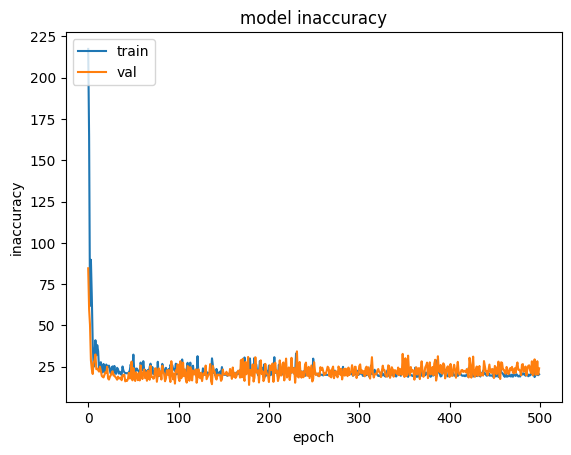

In [34]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model inaccuracy')
plt.ylabel('inaccuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

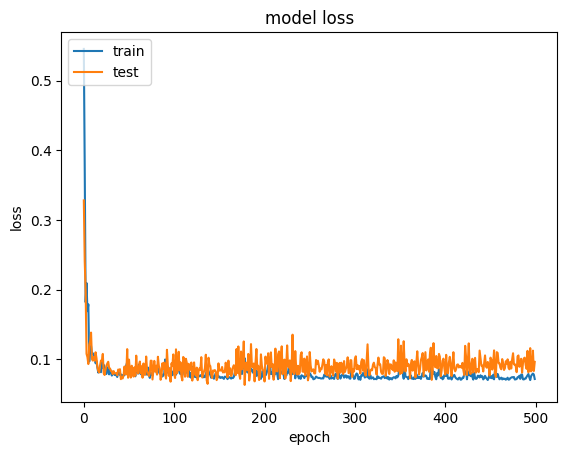

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
# This will allow us to save model weights after training
model.save_weights('./checkpoints/model_weights/ldw_weights')